In [41]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit_nature.second_q.properties import ElectronicDipoleMoment
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
import numpy as np 
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA , SLSQP, L_BFGS_B, SPSA, NELDER_MEAD
from qiskit_algorithms import VQE
from qiskit_algorithms.eigensolvers import NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector 


driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian
dipole: ElectronicDipoleMoment  = problem.properties.electronic_dipole_moment

mapper = JordanWignerMapper()
dipole_ops = dipole.second_q_ops()

x_dipole_op = dipole_ops["XDipole"]
y_dipole_op = dipole_ops["YDipole"]
z_dipole_op = dipole_ops["ZDipole"]

qubit_dipole_ops = {
    "XDipole": mapper.map(x_dipole_op),
    "YDipole": mapper.map(y_dipole_op),
    "ZDipole": mapper.map(z_dipole_op),
}

qubit_dipole_ops_matrix = {
    "XDipole": qubit_dipole_ops["XDipole"].to_matrix(),
    "YDipole": qubit_dipole_ops["YDipole"].to_matrix(),
    "ZDipole": qubit_dipole_ops["ZDipole"].to_matrix(),
}

Dz_op = qubit_dipole_ops["ZDipole"] 
Dx_op = qubit_dipole_ops["XDipole"]
Dy_op = qubit_dipole_ops["YDipole"]
Dz_mat = qubit_dipole_ops_matrix["ZDipole"] 
Dx_mat = qubit_dipole_ops_matrix["XDipole"]
Dy_mat = qubit_dipole_ops_matrix["YDipole"]


second_q_op = hamiltonian.second_q_op()
qubit_jw_op = mapper.map(second_q_op) 

H_0 = qubit_jw_op 
H_static = H_0.to_matrix() 

ansatz = UCC(
    num_spatial_orbitals = problem.num_spatial_orbitals, #2
    num_particles = problem.num_particles, # [1, 1]
    excitations='sd',
    qubit_mapper=mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals = problem.num_spatial_orbitals,
        num_particles = problem.num_particles, 
        qubit_mapper=mapper,
    ),
    reps=1,

)

estimator = Estimator()
optimizer = SLSQP(maxiter=200)
vqe = VQE(estimator, ansatz, optimizer)
res = vqe.compute_minimum_eigenvalue(qubit_jw_op)

numpy_solver = NumPyEigensolver()
exact_result = numpy_solver.compute_eigenvalues(qubit_jw_op)
ref_value = exact_result.eigenvalues

circuit = ansatz.assign_parameters(res.optimal_parameters)
psi_0_vqe = np.array(Statevector(circuit).data)

Gamma = 0.25
E0 = 0.01

def lorentz_pulse(t, E0, Gamma):
    t_float = float(t)
    E_t = (E0 / np.pi) * Gamma / (Gamma**2 + t_float**2)
    return E_t

def H_time_mat(t):
    return H_static - lorentz_pulse(t, E0, Gamma)*Dz_mat

def Hamilton_SP(t, H_0, Dz_op, E0, Gamma):
    t_float = float(t)  
    E_t = (E0 / np.pi) * Gamma / (Gamma**2 + t_float**2)
    V_t = E_t*Dz_op
    H_total_q = H_0 - V_t
    return H_total_q

def H_time(t):
    return Hamilton_SP(t, H_0, Dz_op, E0, Gamma)

In [42]:
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import SparsePauliOp

def calculate_expectation_value(state_vector_flat, pauli_op_sparse, *, assume_normalized=False):
    """
    Trả về <psi|O|psi> (float). An toàn với psi là float-view hoặc complex.
    pauli_op_sparse: SparsePauliOp hoặc Operator (qiskit.quantum_info)
    """
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    try:
        psi = np.asarray(state_vector_flat)

        # Nếu là mảng thực kiểu float-view (do solve_ivp), chuyển về complex view
        if np.isrealobj(psi):
            if psi.ndim != 1 or psi.size % 2 != 0:
                raise ValueError("State vector thực có kích thước lẻ, không thể view sang complex.")
            psi = psi.view(np.complex128)

        # Ép về complex128, dẹt 1D
        psi = np.asarray(psi, dtype=np.complex128).ravel()

        # Chuẩn hóa (nếu muốn đảm bảo chuẩn 1)
        if not assume_normalized:
            nrm = np.linalg.norm(psi)
            if nrm == 0:
                return np.nan
            if not np.isclose(nrm, 1.0):
                psi = psi / nrm

        # Kiểm tra kích thước khớp số qubit của toán tử
        dim = psi.size
        # Với SparsePauliOp: số qubit = pauli_op_sparse.num_qubits
        if hasattr(pauli_op_sparse, "num_qubits"):
            nq = pauli_op_sparse.num_qubits
            if dim != (1 << nq):
                raise ValueError(f"Dim psi={dim} không khớp 2**{nq}.")

        # Dùng API của Qiskit
        sv = Statevector(psi)
        exp_val = sv.expectation_value(pauli_op_sparse)
        # Kết quả về mặt lý thuyết là thực; lấy phần thực có tính đến sai số số học
        return float(np.real_if_close(exp_val))
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan


In [43]:
import numpy as np
from scipy import fftpack
from scipy.constants import speed_of_light, physical_constants

# tốc độ ánh sáng trong a.u.
C_AU = speed_of_light / physical_constants["atomic unit of velocity"][0]
HARTREE_TO_EV = 27.211386245988

# ==== FFT kiểu Hauge: apodize + nửa phổ + mẹo omega ====

def damping(signal, dt, gamma):
    '''damping on signal with decay rate gamma.'''
    t = np.arange(len(signal))*dt
    return signal*np.exp(-gamma*t)

def fourier_transform(signal, dt, gamma):
    """
    Trả về (omega>=0, F) với quy ước Hauge:
      omega = fftfreq(N, dt/(2π))  (đã là rad/a.u.)
      F     = N * (dt/(2π)) * ifft( mu(t)*e^{-γ t} )
    """
    sig = np.asarray(signal, float)
    M = len(sig)//2
    N = 2*M                      # ép N chẵn
    sig = sig[:N]
    # bỏ DC theo đáp ứng tuyến tính: Δμ(t) = μ(t) - μ(0)
    sig = sig - sig[0]
   
    damped = damping(sig, dt, gamma)

    c = dt/(2*np.pi)
    omega = fftpack.fftfreq(N, c)[:M]                   # rad/a.u.
    F = N * c * fftpack.ifft(damped, overwrite_x=True)[:M]
    return omega, F

# ==== ghép phổ và chuẩn hoá (kiểu Hauge) ====
def absorption_spectrum(mu_x, mu_y, mu_z, omega, F_div, normalize=True):
    """
    σ(ω) ∝ ω * Im[(μx+μy+μz)/F_div]
    - F_div = E0 (δ-kick) hoặc E(ω) nếu thật cần (không khuyến nghị).
    """
    S = omega * np.imag((mu_x + mu_y + mu_z) / F_div)
    if normalize:
        return S/S.max()
    # if normalize:
    #     m = np.max(np.abs(S)) or 1.0
    #     return S / m
    # hệ số tuyệt đối (nếu muốn không chuẩn hoá)
    return (4*np.pi/(3*C_AU)) * S

def discrete_spectrum(dipole_moment_xyz, dt, E0, gamma, normalize=True):
    """
    dipole_moment_xyz = (μx(t), μy(t), μz(t)) từ 3 lần kick RIÊNG x/y/z.
    Trả về (omega, σ_iso(ω)).
    """
    mux_t, muy_t, muz_t = dipole_moment_xyz
    omega, mu_x = fourier_transform(mux_t, dt, gamma)
    _,     mu_y = fourier_transform(muy_t, dt, gamma)
    _,     mu_z = fourier_transform(muz_t, dt, gamma)
    sigma_iso = absorption_spectrum(mu_x, mu_y, mu_z, omega, F_div=E0, normalize=normalize)
    return omega, sigma_iso


In [44]:
# --- Hàm giải phương trình Schrödinger chính xác bằng ODE Solver ---
from scipy.integrate import solve_ivp
from qiskit.quantum_info import Statevector, Operator
import numpy as np
import time

print("Bắt đầu chạy mô phỏng chính xác (ODE)...")
start_run_time = time.time()

E0 = 0.01
Gamma = 0.25

dt_tt = 1

def schrodinger_rhs(t, psi_flat):
    H_t_mat = H_static - lorentz_pulse(t, E0, Gamma) * Dz_mat
    return -1j * H_t_mat @ psi_flat


times_1000 =  np.arange(0, 1000, dt_tt ) 
initial_state_vec_for_ode = psi_0_vqe


ode_solution = solve_ivp(
    schrodinger_rhs,
    t_span=[times_1000[0], times_1000[-1]],
    y0=initial_state_vec_for_ode,
    t_eval=times_1000,
    rtol=1e-8,
    atol=1e-8
)

if ode_solution.success:
    print("Giải ODE thành công.")
    all_psi_t_exact_ode = ode_solution.y.T
else:
    print("Giải ODE thất bại:", ode_solution.message)
    all_psi_t_exact_ode = np.array([initial_state_vec_for_ode] * len(times_1000))


muz_plot_1000 = []
for psi_t in all_psi_t_exact_ode:
    exp_val = calculate_expectation_value(psi_t, Dz_op)
    muz_plot_1000.append(exp_val)

end_run_time = time.time()
print(f"Đã tính xong dipole moment từ kết quả ODE. Thời gian: {end_run_time - start_run_time:.2f} giây")

Bắt đầu chạy mô phỏng chính xác (ODE)...
Giải ODE thành công.
Đã tính xong dipole moment từ kết quả ODE. Thời gian: 1.08 giây


In [45]:
# --- Hàm giải phương trình Schrödinger chính xác bằng ODE Solver ---
from scipy.integrate import solve_ivp
from qiskit.quantum_info import Statevector, Operator
import numpy as np
import time


print("Bắt đầu chạy mô phỏng chính xác (ODE)...")
start_run_time = time.time()

H_static_mat_for_ode = H_0.to_matrix(sparse=False)
z_dipole_mat_for_ode = Dz_mat

E0 = 0.01
Gamma = 0.25
def E_field_for_ode(t):
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)


def schrodinger_rhs(t, psi_flat):
    H_t_mat = H_static_mat_for_ode - E_field_for_ode(t) * z_dipole_mat_for_ode
    return -1j * H_t_mat @ psi_flat


times_300 =  np.arange(0, 300, dt_tt) 
initial_state_vec_for_ode = psi_0_vqe


ode_solution = solve_ivp(
    schrodinger_rhs,
    t_span=[times_300[0], times_300[-1]],
    y0=initial_state_vec_for_ode,
    t_eval=times_300,
    rtol=1e-8,
    atol=1e-8
)

if ode_solution.success:
    print("Giải ODE thành công.")
    all_psi_t_exact_ode = ode_solution.y.T
else:
    print("Giải ODE thất bại:", ode_solution.message)
    all_psi_t_exact_ode = np.array([initial_state_vec_for_ode] * len(times_300))


muz_plot_exact_ode = []
for psi_t in all_psi_t_exact_ode:
    exp_val = calculate_expectation_value(psi_t, Dz_op)
    muz_plot_exact_ode.append(exp_val)

end_run_time = time.time()
print(f"Đã tính xong dipole moment từ kết quả ODE. Thời gian: {end_run_time - start_run_time:.2f} giây")

Bắt đầu chạy mô phỏng chính xác (ODE)...
Giải ODE thành công.
Đã tính xong dipole moment từ kết quả ODE. Thời gian: 0.34 giây


Đang tính phổ cho 0-300 a.u. (50 điểm)...


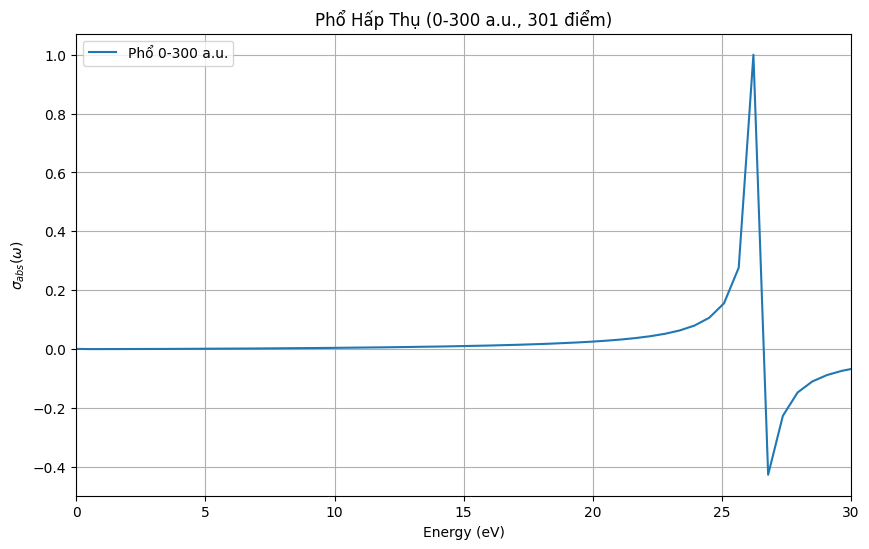

\nĐang tính phổ cho 0-1000 a.u. (250 điểm)...


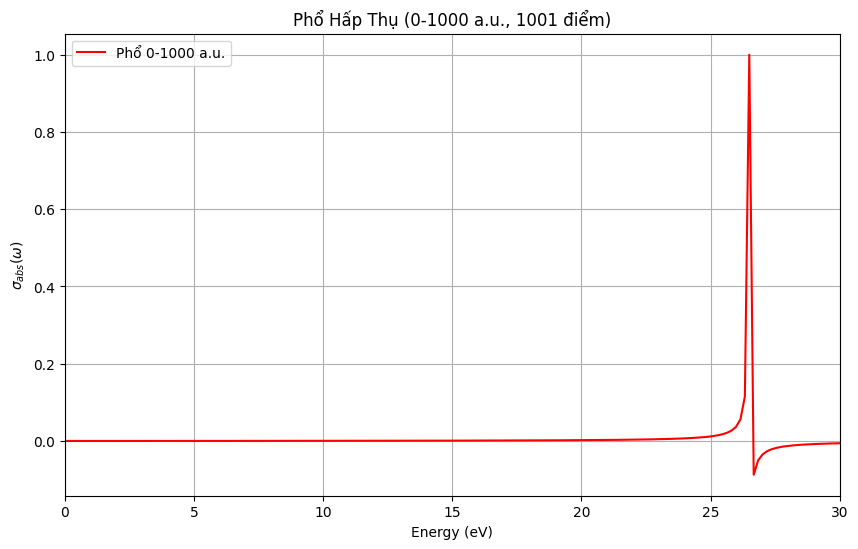

Đang vẽ đồ thị so sánh...


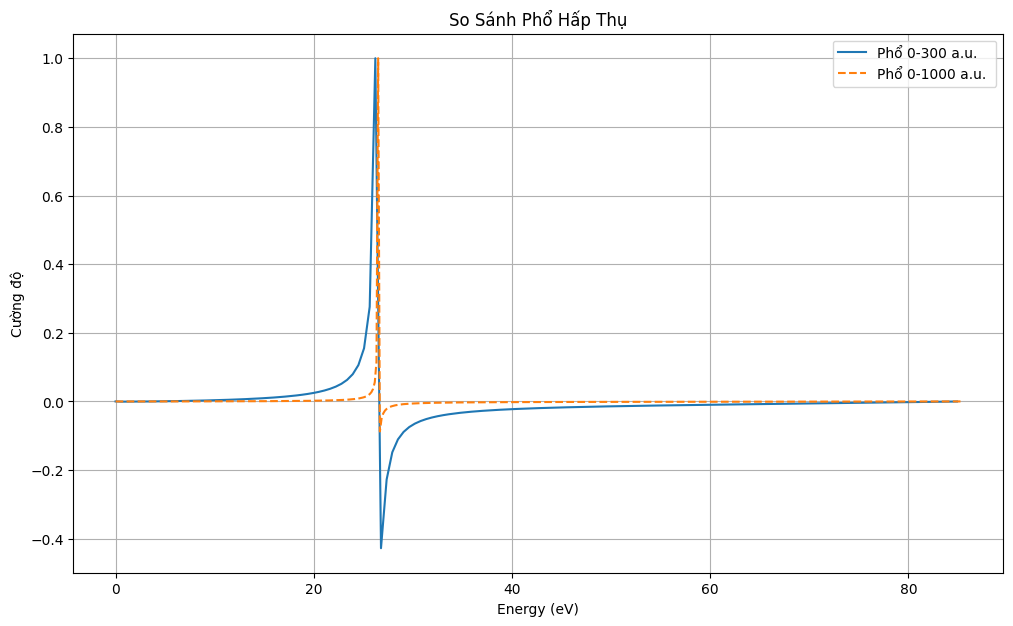

In [47]:
import matplotlib.pyplot as plt
hartree_to_ev = 27.211386245988
gamma = 0.001
if 'muz_plot_exact_ode' in locals() and len(muz_plot_exact_ode) > 1:
    print("Đang tính phổ cho 0-300 a.u. (50 điểm)...")
    dt_300 = times_300[1] - times_300[0]
    E_t_300 = E0
    mux = np.zeros_like(muz_plot_exact_ode)
    muy = np.zeros_like(muz_plot_exact_ode)
    muz_300 = np.asarray(muz_plot_exact_ode, float)
    omega_300, sigma_300 = discrete_spectrum(
                            (mux, muy, muz_300),
                            dt_tt,
                            E0,
                            gamma)


    plt.figure(figsize=(10, 6))
    plt.plot(omega_300 * hartree_to_ev, sigma_300, label='Phổ 0-300 a.u.')
    plt.title('Phổ Hấp Thụ (0-300 a.u., 301 điểm)')
    plt.xlabel("Energy (eV)")
    plt.ylabel("$\\sigma_{abs}(\\omega)$")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 30)
    plt.show()

if 'muz_plot_1000' in locals() and len(muz_plot_1000) > 1:
    print("\\nĐang tính phổ cho 0-1000 a.u. (250 điểm)...")
    dt_1000 = times_1000[1] - times_1000[0]
    E_t_1000 = E0
    mux = np.zeros_like(muz_plot_1000)
    muy = np.zeros_like(muz_plot_1000)
    muz_1000 = np.asarray(muz_plot_1000, float)
    omega_1000, sigma_1000 = discrete_spectrum(
                        (mux, muy, muz_1000),
                        dt_tt,
                        E0,
                        gamma)


    plt.figure(figsize=(10, 6))
    plt.plot(omega_1000 * hartree_to_ev, sigma_1000, label='Phổ 0-1000 a.u.', color='red')
    plt.title('Phổ Hấp Thụ (0-1000 a.u., 1001 điểm)')
    plt.xlabel("Energy (eV)")
    plt.ylabel("$\\sigma_{abs}(\\omega)$")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 30)
    plt.show()


print("Đang vẽ đồ thị so sánh...")
plt.figure(figsize=(12, 7))

plt.plot(omega_300 * hartree_to_ev, sigma_300, label='Phổ 0-300 a.u. ')
plt.plot(omega_1000 * hartree_to_ev, sigma_1000, label='Phổ 0-1000 a.u. ', linestyle='--')

plt.title('So Sánh Phổ Hấp Thụ')
plt.xlabel("Energy (eV)")
plt.ylabel("Cường độ")
plt.grid(True)
plt.legend()
#plt.xlim(0, 30) 


plt.show()   

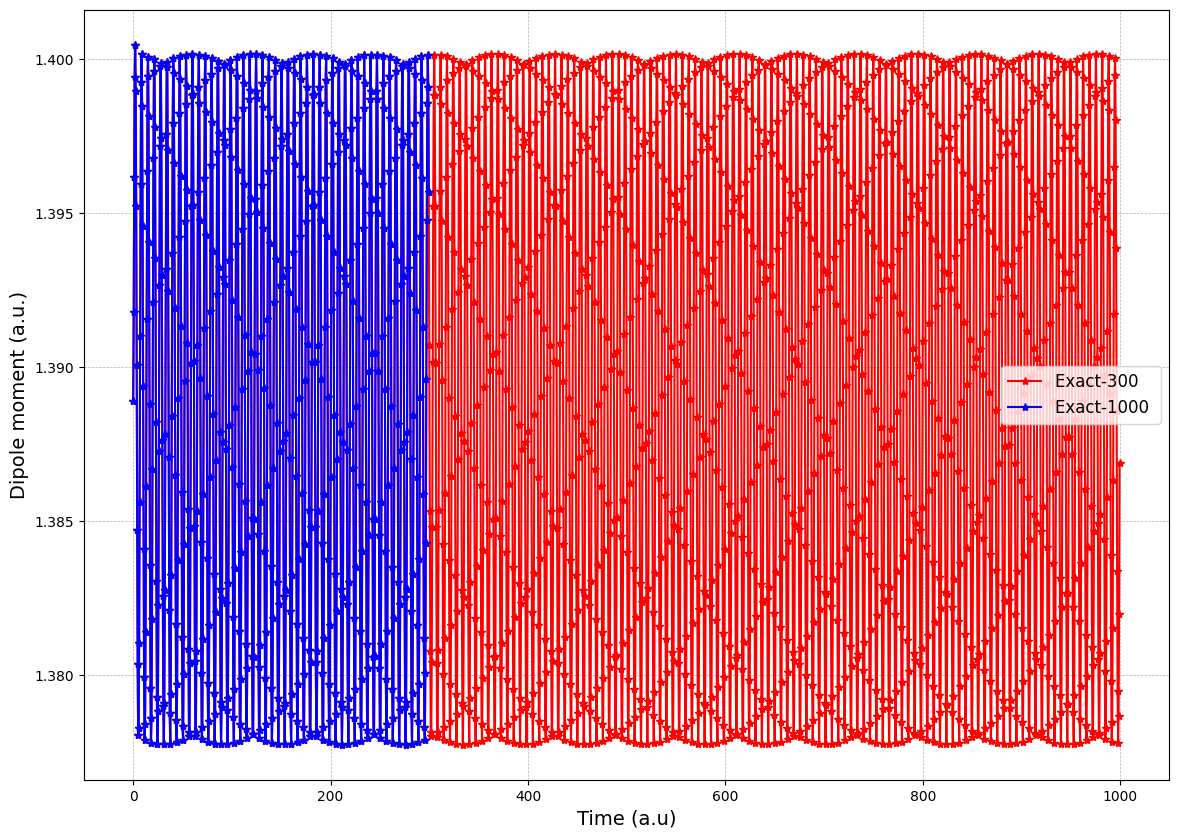

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 10))
if 'muz_plot_1000' in locals() or 'muz_plot_1000' in globals():
    plt.plot(times_1000, muz_plot_1000, label="Exact-300 ", color='red',marker='*', linestyle='-')
if 'muz_plot_exact_ode' in locals() or 'muz_plot_exact_ode' in globals():
    plt.plot(times_300, muz_plot_exact_ode, label="Exact-1000 ", color='blue',marker='*', linestyle='-')


# --- Định dạng đồ thị ---
plt.xlabel("Time (a.u)", fontsize=14)
plt.ylabel("Dipole moment (a.u.)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
